## Hi
---
* Roll : ES20BTECH11015
* Requirements - Numpy, torch, PIL, tqdm (for progress bar ), opencv for (heatmaps in CAM)

In [31]:
import torch
import numpy as np
import torchvision.datasets as datasets
import torchvision
from tqdm import tqdm
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [32]:
# import a trained ResNet model for ILSVRC 2012
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# model  = resnet50(pretrained=True)

In [33]:
imgs_processed = []
preprocess = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR), # convert h X w images to 256 X 256
        transforms.CenterCrop(224), # crop to 224 X 224
        transforms.ToTensor(), # convert PIL image to (c, h, w) tensor in range [0, 1]
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
    ])

for i in range(1, 6):
    img = Image.open(f"./Dataset/i{i}.jpg").convert('RGB')
    img = preprocess(img)
    img.requires_grad = True
    imgs_processed.append(img)
    print(f'Image {i} shape: {imgs_processed[-1].shape}')

Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


In [34]:
def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm

In [35]:
# iterate over files in the Dataset Directory
# imgs = [Image.open('Dataset/' + path) for path in os.listdir('Dataset')]
imgs = imgs_processed

In [36]:
# plt.imshow(imgs[3])
# to_tensor = transforms.ToTensor()
# data = [to_tensor(img) for img in imgs]

In [37]:
## Extract labels from file named 'imagenet_labels.txt'
labels = []
for line in open('imagenet_labels.txt'):
    labels.append(line.strip())

In [38]:
# Preprocess the image by making it a single batch of size 1 and passing it through the Resnet
# unsqueeze = transforms.Lambda(lambda x: x.unsqueeze(0))
# X = [unsqueeze(img) for img in imgs]
# X[0].requires_grad = True # set the requires_grad attribute to True
# X[3].requires_grad = True # set the requires_grad attribute to True
X = imgs
op = model(X[0].unsqueeze(0))
op = model(X[3].unsqueeze(0))
print(op.shape)
print(X[0].shape)

torch.Size([1, 1000])
torch.Size([3, 224, 224])


In [39]:
# Get the index of the maximum value in the output vector
index = op.argmax().item()
print(index)
print(labels[index])

851
television


In [40]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
def vanilla_backprop(image, model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    print(image.requires_grad)
    global labels
    # image.requires_grad = True
    if (image.grad is not None):
        print('grad is not none')
        image.grad.data.zero_()
    model.zero_grad()
    print(image.requires_grad)
    # image.requires_grad = True
    op  = model(torch.unsqueeze(image, 0))
    print(op.shape)
    index = op.argmax().item()
    label = labels[index]
    img = image.clone().detach()
    ax[0].imshow(img.permute(1, 2, 0))
    # compute the backpropagation of the max softmax probability
    op[0,index].backward()
    # get the gradients
    print(image.grad.shape)
    grad = image.grad.data
    ax[1].imshow(normalize(grad.permute(1, 2, 0)))
    ax[1].set_title('Vanilla Backpropagation')
    ax[0].set_title('Original Image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True
True
torch.Size([1, 1000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
True
True
torch.Size([1, 1000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
True
True
torch.Size([1, 1000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
True
True
torch.Size([1, 1000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
True
True
torch.Size([1, 1000])
torch.Size([3, 224, 224])


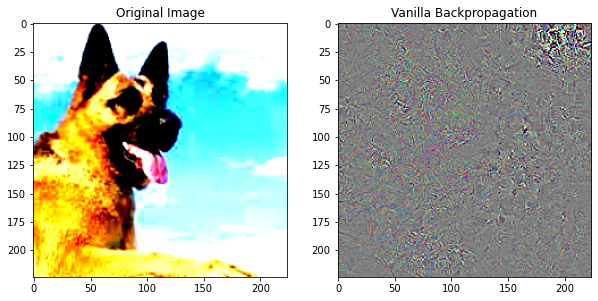

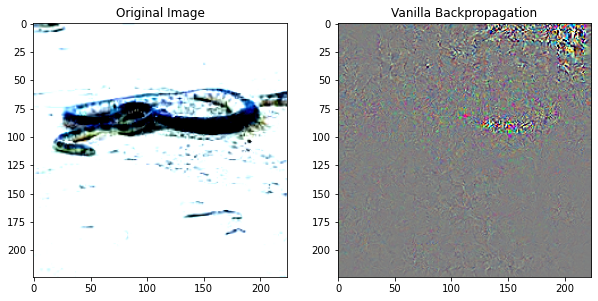

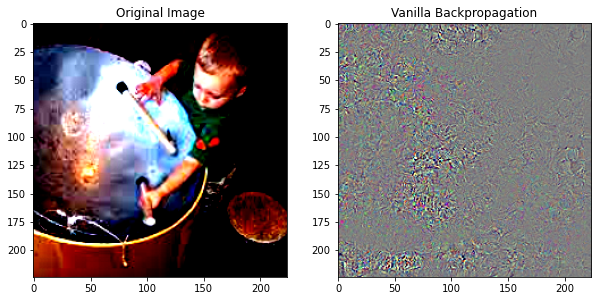

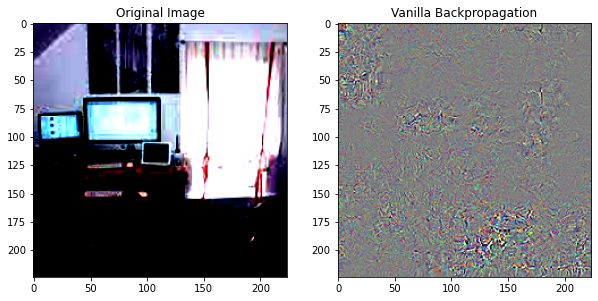

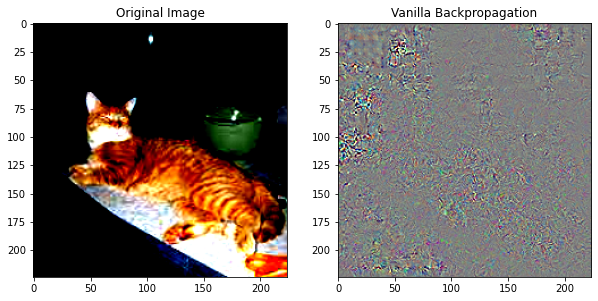

In [42]:
# vanilla_backprop(X[3], model)
# vanilla_backprop(X[0], model)
for i in range(5):
    vanilla_backprop(X[i], model)

In [43]:
feature_maps = []
feature_hash = {}
count = 0
handles_forward = []
handles_backward = []

In [44]:
# defibne custom backward hook 

def backward_hook(module, grad_in, grad_out):
    global feature_maps
    global feature_hash
    global count 
    
    activation = feature_maps.pop()
    if(activation[0].shape != grad_in[0].shape):
        count = count + 1
    
    # create  a mask
    if(isinstance(module, torch.nn.ReLU)):
        # print(count)
        mask = (activation[0] > 0).float()
        # print(mask.shape, grad_in[0].shape, grad_out[0].shape)
        return (mask * torch.clamp(grad_in[0], min=0.0),) # gradient clamped at negative values to zero

In [45]:
# set the hook to the model
def set_backward_hooks(model):
    for name, module in model.named_modules():
        if(isinstance(module, torch.nn.ReLU)):
            handles_backward.append(module.register_backward_hook(backward_hook))
            # print("Backward Hooked", name)
            

In [46]:
def forward_hook(module, input, output):
    global feature_maps
    if(isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d)):
        feature_maps.append(input)
    return output

In [47]:
def forward_all_hook(module, input, output):
    global feature_maps
    if(isinstance(module, torch.nn.ReLU)):
        feature_maps.append(input)
    return output

In [48]:
def set_forward_all_hooks(model):
    global handles_forward
    for name, module in model.named_modules():
        if(isinstance(module, torch.nn.ReLU)):
            handles_forward.append(module.register_forward_hook(forward_all_hook))
            # print("Forward All Hooked", name)

In [49]:
def set_forward_hooks(model): 
    for name, module in model.named_modules():
        if(isinstance(module, torch.nn.modules.pooling.AdaptiveAvgPool2d)):
            module.register_forward_hook(forward_hook)
            # print("Forward Hooked", name)

In [50]:
def guided_backprop(image, model, count):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    global labels
    global feature_maps
    global backward_hook
    global set_backward_hooks
    
    # apply the Hooks onto the model and Zero the gradients
    image.requires_grad = True
    if image.grad is not None:
        image.grad.data.zero_()
    model.zero_grad()
         
    set_backward_hooks(model)
    set_forward_all_hooks(model)

    # compute output
    op  = model(torch.unsqueeze(image, 0))
    index = op.argmax().item()
    label = labels[index]
    
    # show the original image
    img = image.clone().detach()
    ax[0].imshow(img.permute(1, 2, 0))
    
    # compute the backpropagation of the max softmax probability
    op[0, index].backward()
    
    # get the gradients
    grad = image.grad.data
    
    ax[1].imshow(normalize(grad.permute(1, 2, 0)))
    
    ax[1].set_title('Guided Backpropagation')
    ax[0].set_title('Original Image')
    # ax[1].savefig('guided_backprop-' + str(count) + '.png')
    return normalize(grad.permute(1, 2, 0))

### Guided Backpropagation 

To do this we need to set the gradients to zero wherever the gradients contribute negatively to the softmax probability 
of the predicted class

In [51]:
guided_grads = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


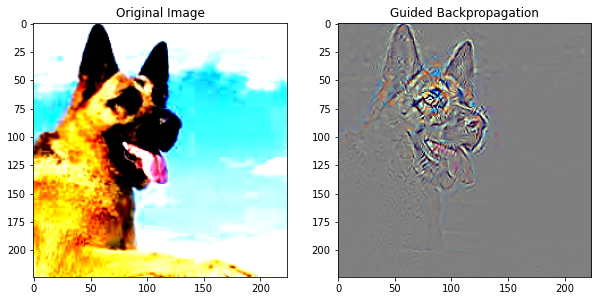

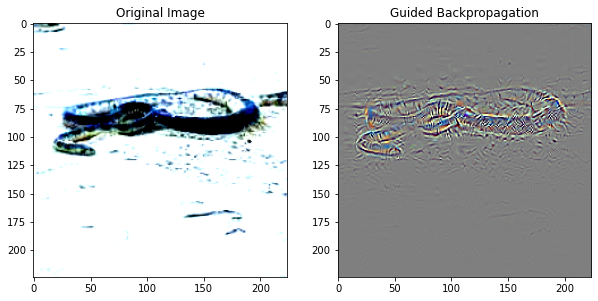

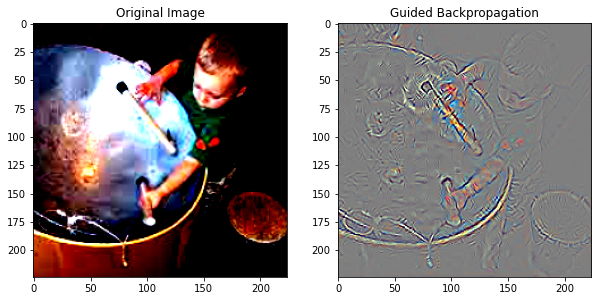

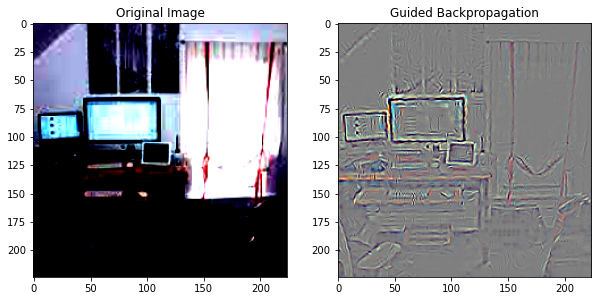

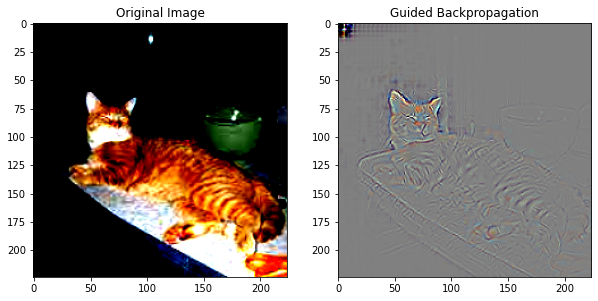

In [52]:
# RUN THIS IN ORDER, DO NOT RUN IT SEPARATELY
for i in range(5):
    guided_grads.append(guided_backprop(X[i], model, i))

# grad = guided_backprop(X[3], model)

In [53]:
def clean_handles():
    feature_maps  = []
    global handles_forward
    global handles_backward
    for handle in handles_forward:
        handle.remove()
    for handles_backward in handles_backward:
        handles_backward.remove()
    handles_forward = []
    handles_backward = []

clean_handles()

### Class Activation Maps

---

In order to make the class activation maps useful one must extract the layer weights and activations from the model


$$
\begin{align}
    M_{x,y} &= \sum_{k=1}^{K} W_{c,k} \cdot A_{k,x,y} \\
    &= A_{x, y , :} \cdot \vec{W}_{c, :} \\
\end{align}
$$

In [54]:
feature_maps = []

In [55]:
def get_CAM(pre_pool_weight, final_weights, index, input_size):
    channels, height, width = pre_pool_weight.shape # 2048, 7, 9
    cam = np.zeros((height, width), dtype=np.float32)
    for i in range(channels):
        cam += pre_pool_weight[i, :, :] * final_weights[index, i] # matrix into scalar multiplication
    # now we must upsample the cam to the size of the input image
    cam = np.maximum(cam, 0) # ReLU can be done here (it is usually done)
    return cv2.resize(cam, (input_size[1], input_size[0]))

In [56]:
def CAM(image, model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    global labels
    global feature_maps
    global backward_hook
    global set_backward_hooks
    
    # apply the Hooks onto the model and Zero the gradients
    image.requires_grad = True
    if image.grad is not None:
        image.grad.data.zero_()
    model.zero_grad()
    set_forward_hooks(model)  

    # compute output
    op  = model(torch.unsqueeze(image,0))
    index = op.argmax().item()
    label = labels[index]
    
    # show the original image
    img = image.clone().detach()
    ax[0].imshow(img.permute(1, 2, 0))
    
    # compute the backpropagation of the max softmax probability
    op[0, index].backward()
    print("Feature Maps = ",len(feature_maps))
    # get the weights that are needed
    pre_pool_weight = feature_maps[0][0].detach().numpy()[0]
    final_weights = model.fc.weight.detach().numpy()
    # print(pre_pool_weight.shape, final_weights.shape, image.shape)
    input_size = image.shape[1:]
    
    # print(pre_pool_weight.shape, final_weights.shape, input_size)
    # call the CAM function
    grads = get_CAM(pre_pool_weight, final_weights, index, input_size)
    # ax[0].imshow(grads.permute(1, 2, 0).detach().numpy())
    
    # visualize the CAM
    grads = normalize(grads)
    print(np.min(grads), np.max(grads))
    
    heatmap = cv2.applyColorMap(np.uint8(255*grads), cv2.COLORMAP_JET)
    print(grads.shape)
    print(heatmap.shape)
    # result = heatmap* 0.0001 + img[0].permute(1, 2, 0).detach().numpy()
    
    ax[1].imshow(img.permute(1, 2, 0).detach().numpy())
    ax[1].imshow(heatmap, alpha=0.5)
    ax[1].set_title('CAM')
    ax[0].set_title('Original Image')
    heatmap_cam = heatmap
    return heatmap_cam


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Maps =  1
0.4396063 0.8914461
(224, 224)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Maps =  3
0.4101128 0.96883774
(224, 224)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Maps =  6
0.44506606 1.0
(224, 224)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Maps =  10
0.44990396 1.0
(224, 224)
(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature Maps =  15
0.4717581 1.0
(224, 224)
(224, 224, 3)


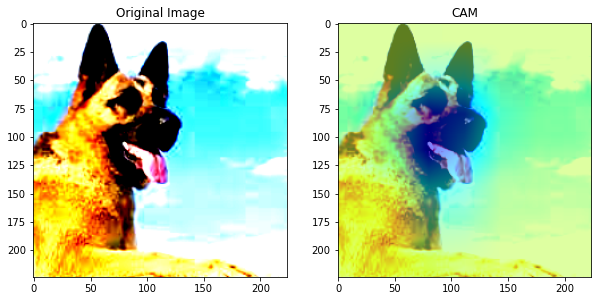

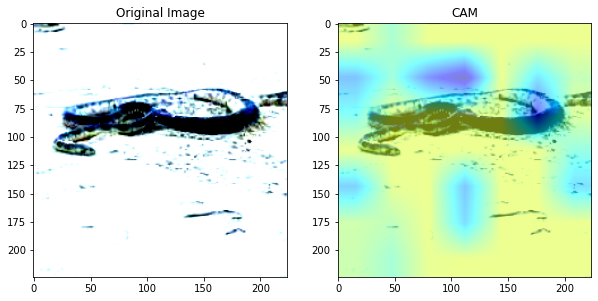

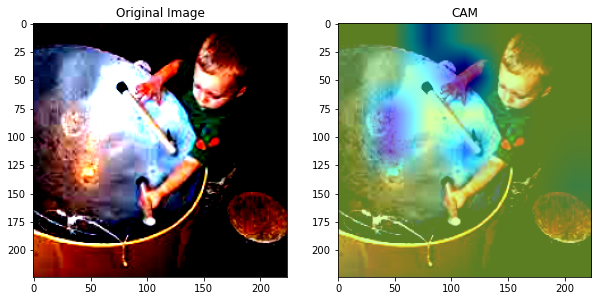

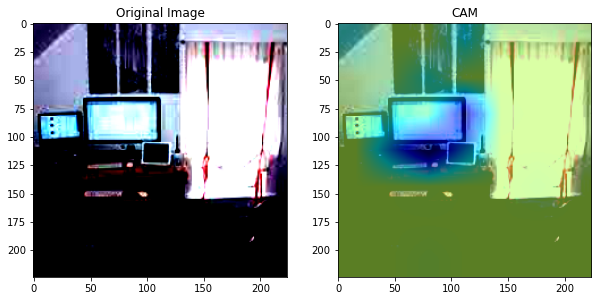

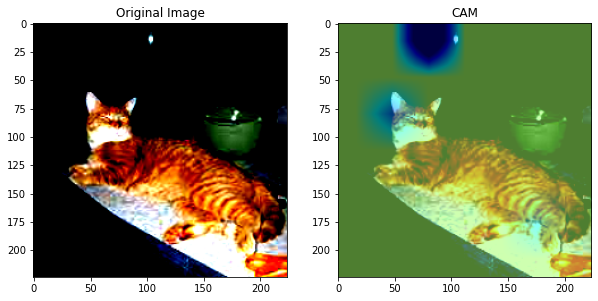

In [57]:
# heatmap  = CAM(X[3], model)
heatmaps = []
for i in range(5):
    heatmaps.append(CAM(X[i], model))

### Guided Gradient Weighted Class Activation Maps

First thing to note that since we are using an adaptive pooling layer, both CAM and GRADCAM will yield the same results.
since the weights are equal to the gradients anyway. 
So using the weights and the gradients are equivalent
we need only take the hadamard product of both at the end and then visualize


In [58]:
print(len(guided_grads), len(heatmaps))
print(guided_grads[0].shape, heatmaps[0].shape)

5 5
torch.Size([224, 224, 3]) (224, 224, 3)


In [59]:
clean_handles()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


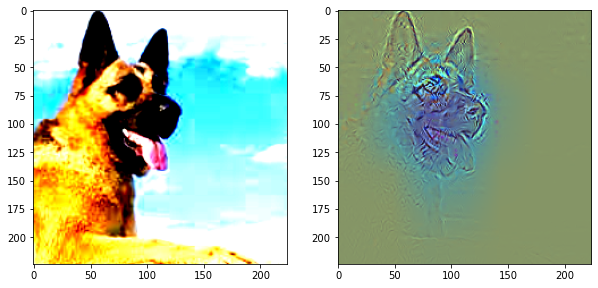

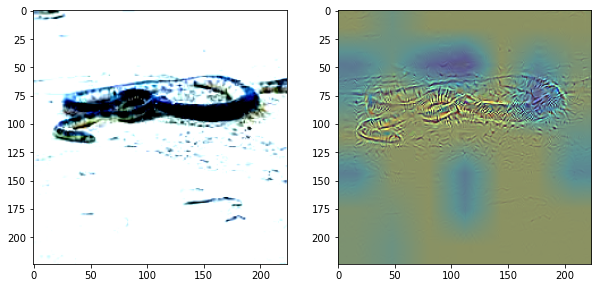

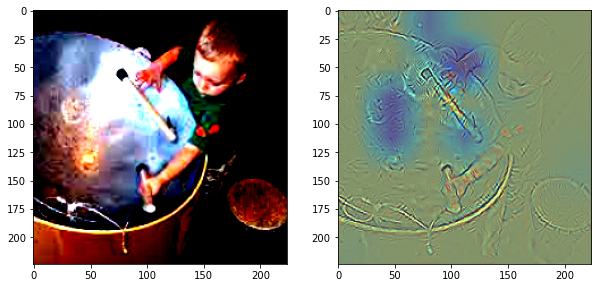

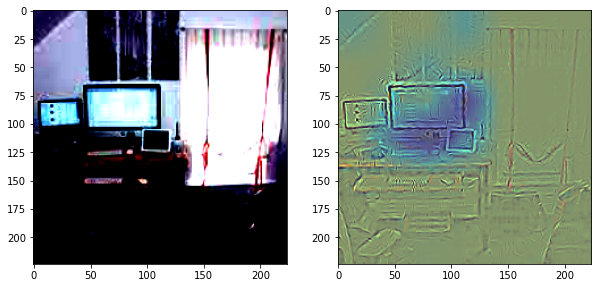

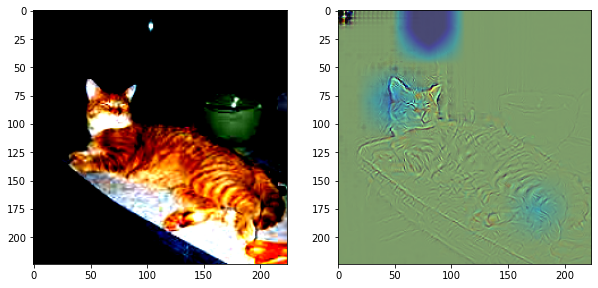

In [60]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    image = X[i]
    img = image.clone().detach()
    ax[0].imshow(img.permute(1, 2, 0))
    heatmap = normalize(heatmaps[i])
    net = guided_grads[i] * heatmap
    ax[1].imshow(normalize(net))